In [1]:
import kagglehub
path = kagglehub.dataset_download('awsaf49/coco-2017-dataset')
print(path)

/kaggle/input/coco-2017-dataset


2025-05-06 01:51:08.083371: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746496268.277082      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746496268.332920      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


✅ Device: cuda
🔒 Vision encoder frozen


Epoch 1/5: 100%|██████████| 2500/2500 [36:40<00:00,  1.14it/s, loss=0.0367]


✅ Epoch 1 done. Avg loss: 0.0460


Epoch 2/5: 100%|██████████| 2500/2500 [36:40<00:00,  1.14it/s, loss=0.0333]


✅ Epoch 2 done. Avg loss: 0.0358


Epoch 3/5: 100%|██████████| 2500/2500 [36:41<00:00,  1.14it/s, loss=0.0266]


✅ Epoch 3 done. Avg loss: 0.0272


Epoch 4/5: 100%|██████████| 2500/2500 [36:40<00:00,  1.14it/s, loss=0.0192]


✅ Epoch 4 done. Avg loss: 0.0192


Epoch 5/5: 100%|██████████| 2500/2500 [36:39<00:00,  1.14it/s, loss=0.00968]


✅ Epoch 5 done. Avg loss: 0.0128
💾 Model saved to /kaggle/working/blip-finetuned-coco

📸 Caption Prediction on 10 validation images:


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


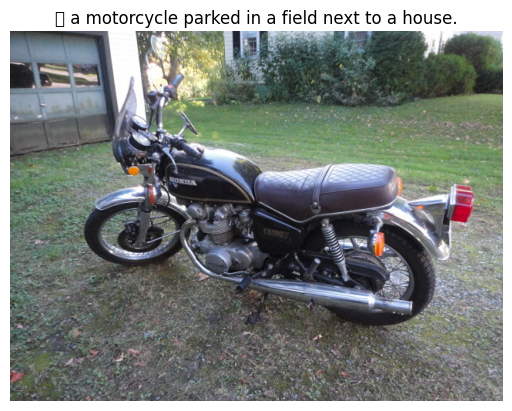

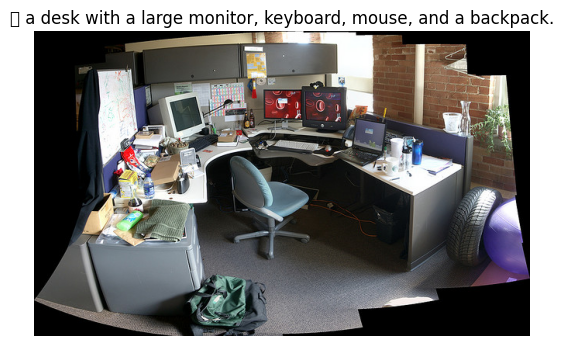

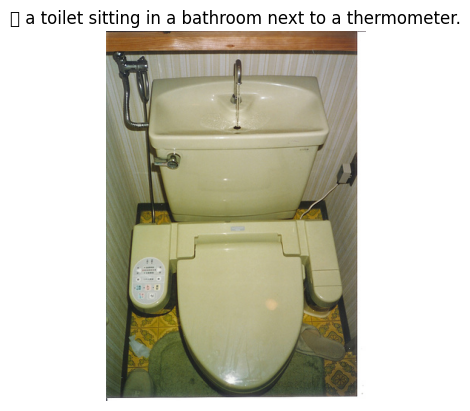

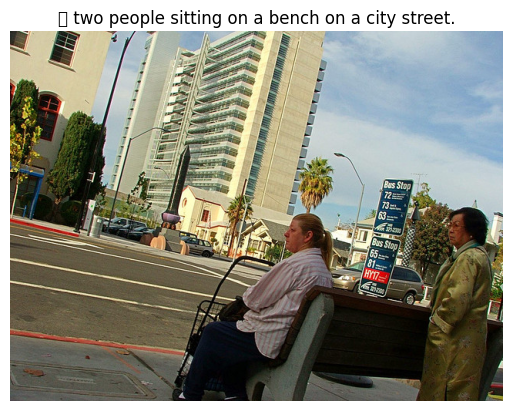

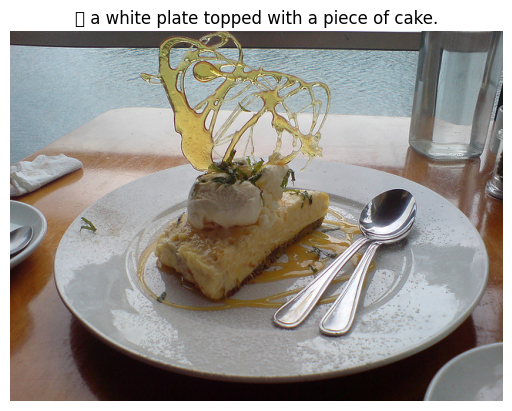

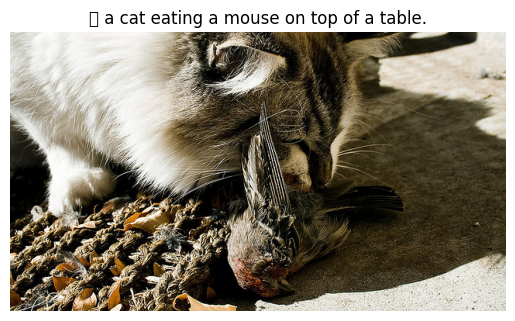

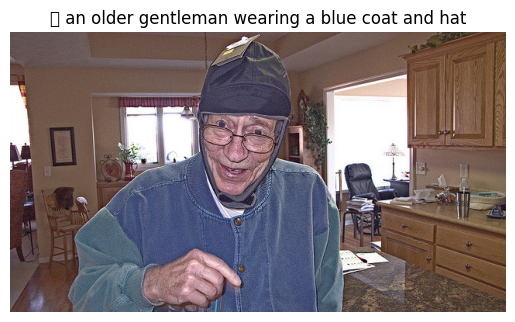

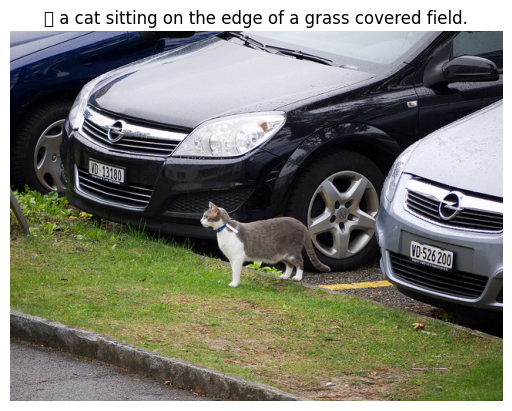

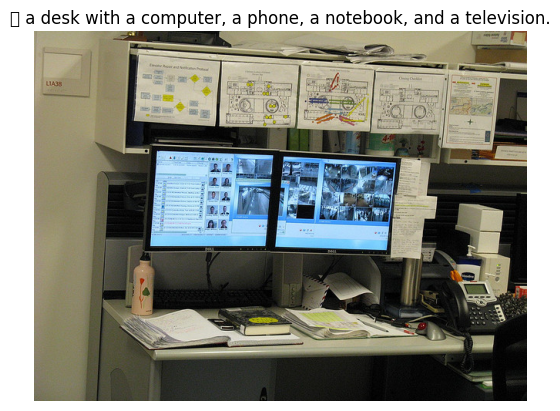

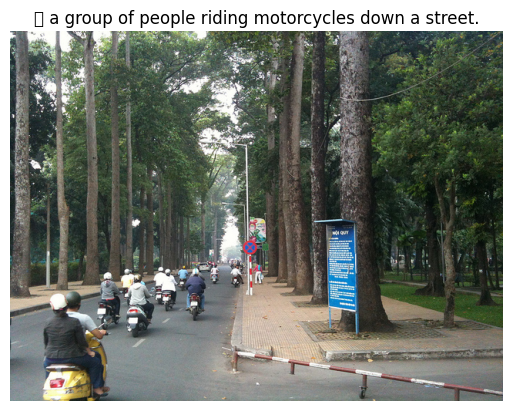

In [2]:
from transformers import BlipProcessor, BlipForConditionalGeneration, get_scheduler
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import os
import json
from tqdm import tqdm
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# --- Cấu hình thiết bị ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Device:", device)

# --- Load BLIP base model + processor ---
model_path = "/kaggle/input/dl_cuoiky_blip/transformers/default/1"

# Load model và processor từ checkpoint
processor = BlipProcessor.from_pretrained(model_path)
model = BlipForConditionalGeneration.from_pretrained(model_path).to(device)

# --- Freeze vision encoder nếu cần giảm RAM ---
for param in model.vision_model.parameters():
    param.requires_grad = False
print("🔒 Vision encoder frozen")

# --- Load COCO caption dataset ---
def load_coco_captions(annotation_path, image_dir, max_images=5000, skip_images=0):
    with open(annotation_path, 'r') as f:
        data = json.load(f)

    id_to_filename = {item['id']: item['file_name'] for item in data['images']}

    items = []
    image_counter = {}

    for ann in data['annotations']:
        img_id = ann['image_id']
        caption = ann['caption']

        if img_id in id_to_filename:
            if image_counter.get(img_id, 0) >= 1:
                continue

            if len(set(image_counter.keys())) < skip_images:
                image_counter[img_id] = 1
                continue

            path = os.path.join(image_dir, id_to_filename[img_id])
            if os.path.exists(path):
                items.append((path, caption))
                image_counter[img_id] = 1

        if len(items) >= max_images:
            break

    return items

# --- Dataset class ---
class CocoBLIPDataset(Dataset):
    def __init__(self, data, processor):
        self.data = data
        self.processor = processor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, caption = self.data[idx]
        image = Image.open(img_path).convert("RGB")
        inputs = self.processor(images=image, text=caption, return_tensors="pt", padding="max_length", truncation=True)
        return {k: v.squeeze(0) for k, v in inputs.items()}

# --- Load dữ liệu ---
train_data = load_coco_captions(
    "/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_train2017.json",
    "/kaggle/input/coco-2017-dataset/coco2017/train2017",
    max_images=20000,
    skip_images=20000  # ⬅️ bỏ qua 20k ảnh đầu tiên
)

val_data = load_coco_captions(
    "/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_val2017.json",
    "/kaggle/input/coco-2017-dataset/coco2017/val2017",
    max_images=2000
)

train_dataset = CocoBLIPDataset(train_data, processor)
val_dataset = CocoBLIPDataset(val_data, processor)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=8)

# --- Optimizer & Scheduler ---
optimizer = AdamW(model.parameters(), lr=5e-5)
total_steps = len(train_loader) * 10
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# --- Training loop ---
model.train()
num_epochs = 5

for epoch in range(num_epochs):
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch, labels=batch['input_ids'])
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    print(f"✅ Epoch {epoch+1} done. Avg loss: {avg_loss:.4f}")

# --- Save model ---
model.save_pretrained("/kaggle/working/blip-finetuned-coco")
processor.save_pretrained("/kaggle/working/blip-finetuned-coco")
print("💾 Model saved to /kaggle/working/blip-finetuned-coco")

# --- Test lại mô hình trên 10 ảnh validation và hiển thị ---
model.eval()
print("\n📸 Caption Prediction on 10 validation images:")
for img_path, _ in val_data[:10]:
    img = Image.open(img_path).convert("RGB")
    inputs = processor(images=img, return_tensors="pt").to(device)
    out = model.generate(**inputs, max_new_tokens=30)
    caption = processor.decode(out[0], skip_special_tokens=True)

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"🔹 {caption}", fontsize=12)
    plt.show()

In [3]:
import shutil

# Đường dẫn thư mục model
model_dir = "/kaggle/working/blip-finetuned-coco"

# Đường dẫn file zip muốn tạo
output_zip = "/kaggle/working/blip-finetuned-coco.zip"

# Nén toàn bộ thư mục
shutil.make_archive(base_name=output_zip.replace(".zip", ""), format='zip', root_dir=model_dir)

print("✅ Đã nén xong mô hình:", output_zip)


✅ Đã nén xong mô hình: /kaggle/working/blip-finetuned-coco.zip
